# Customer Churn Prediction by Alan Hsiao

## **Data Processing**

In [1]:
import pandas as pd
import numpy as np

In [2]:
# copy from the EDA file
def dataprep_EDA(filepath:str):
    data = pd.read_csv(filepath, header=0)
    data.columns = data.columns.str.replace(' ', '')
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)
    data.drop(['CustomerID'], inplace=True, axis=1)
    int_col = ['Age', 'Tenure', 'UsageFrequency', 'SupportCalls', 'PaymentDelay', 'TotalSpend', 'LastInteraction', 'Churn']
    for col in int_col:
        data[col] = data[col].astype(int)
    return data

In [3]:
data = dataprep_EDA(r'C:\Users\alan\Desktop\Project\Churn Prediction\dataset\customer_churn_dataset-training-master.csv')
data.head()

,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn
0,30,Female,39,14,5,18,Standard,Annual,932,17,1
1,65,Female,49,1,10,8,Basic,Monthly,557,6,1
2,55,Female,14,4,6,18,Basic,Quarterly,185,3,1
3,58,Male,38,21,7,7,Standard,Monthly,396,29,1
4,23,Male,32,20,5,8,Basic,Monthly,617,20,1


In [4]:
data.Gender = data.Gender.apply(lambda x: 1 if x == 'Male' else 0)

# Apply one-hot encoding to two variables
data = pd.get_dummies(data, columns=['SubscriptionType', 'ContractLength'])
data.head()

,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,TotalSpend,LastInteraction,Churn,SubscriptionType_Basic,SubscriptionType_Premium,SubscriptionType_Standard,ContractLength_Annual,ContractLength_Monthly,ContractLength_Quarterly
0,30,0,39,14,5,18,932,17,1,0,0,1,1,0,0
1,65,0,49,1,10,8,557,6,1,1,0,0,0,1,0
2,55,0,14,4,6,18,185,3,1,1,0,0,0,0,1
3,58,1,38,21,7,7,396,29,1,0,0,1,0,1,0
4,23,1,32,20,5,8,617,20,1,1,0,0,0,1,0


## **Feature Selection**

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

### **Correlation between features**

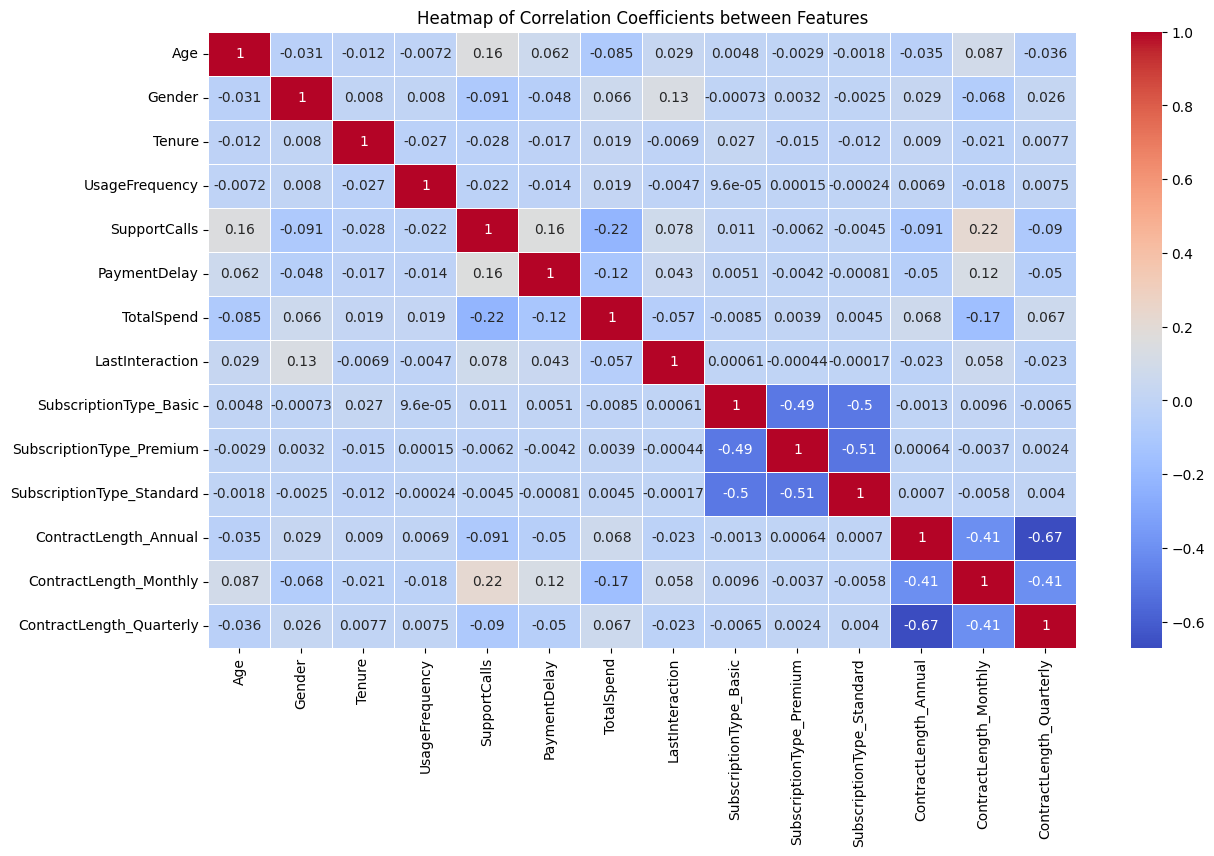

In [6]:
X = data.drop(['Churn'], axis=1)
corr_matrix = X.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlation Coefficients between Features')
plt.show()

Starting feature selection by looking at the correlation between features, we can observe that features that are produced by one-hot encoding have higher correlation with one another. Overall, obvious collinearity is not present here. Note that dummy encoding here is also applicable, but for better readability, we chose to use one-hot encoding. 

### **Correlation with target `Churn`**

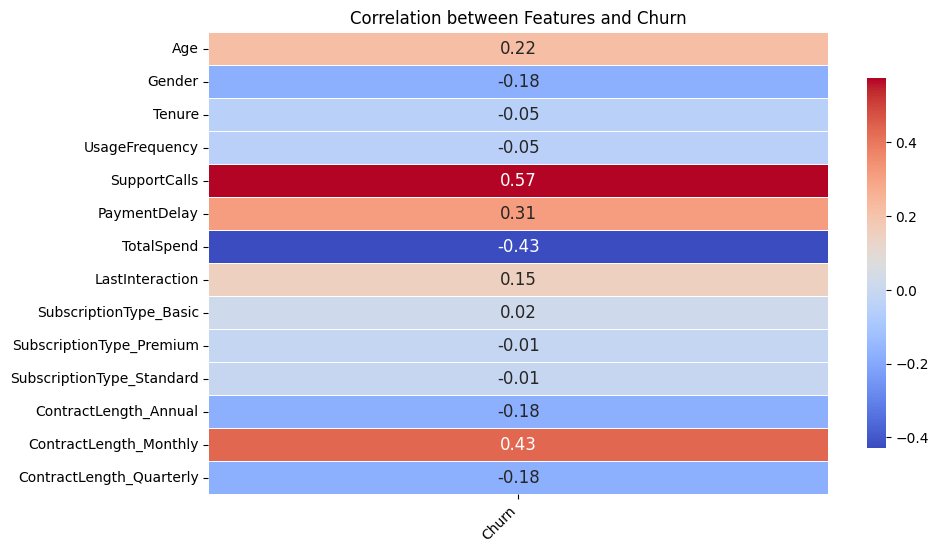

In [7]:
corr_matrix = data.corr()
target_corr = corr_matrix[['Churn']].drop('Churn')

plt.figure(figsize=(10, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', fmt=".2f", 
            annot_kws={"size": 12}, cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation between Features and Churn', fontsize=12)
plt.show()

By looking at the correlation between each feature and the dependent variable, we should note down features that have high absolute value of correlation coefficient with the target variable. Hereby `SupportCalls`, `PaymentDelay`, `TotalSpend`, and `ContractLength_Monthly` are noted for future reference.

### **Probability Density Curve (PDF)**

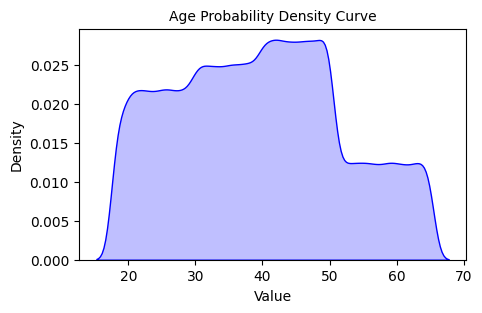

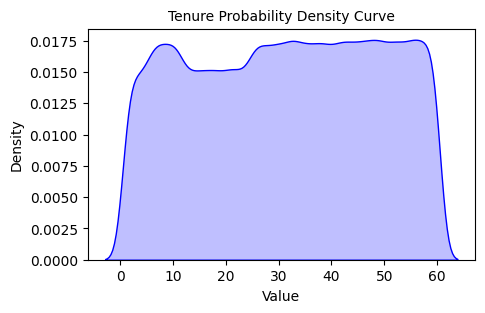

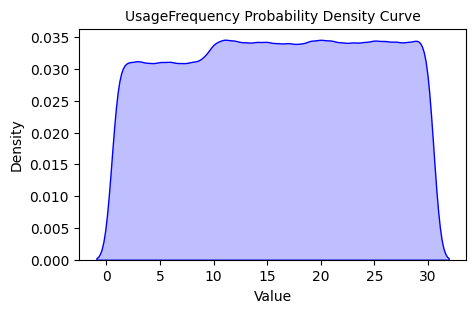

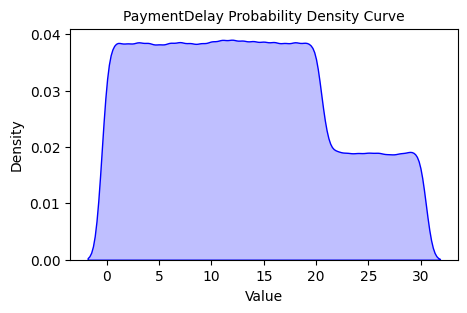

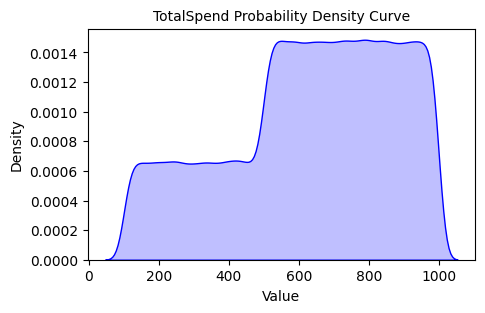

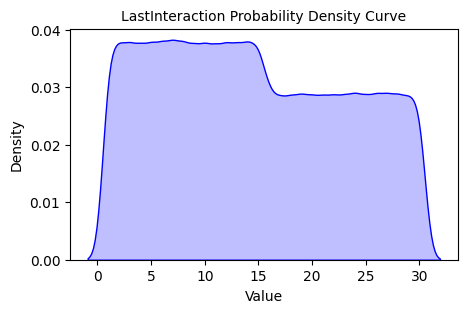

In [8]:
num_col = ['Age', 'Tenure', 'UsageFrequency', 'PaymentDelay', 'TotalSpend', 'LastInteraction']
for col in num_col: 
    plt.figure(figsize=(5, 3))
    sns.kdeplot(data[col], fill=True, color="blue")
    plt.title(f'{col} Probability Density Curve', fontsize=10)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.show()

Some traits and shapes of probability density curve of numerical variables are indicators whether those variables are a good predictor or not. If the shape of the curve is too flat, it may indicate that most of the values are almost equally likely. This lack of variability means that the variable does not provide much information to distinguish between different outcomes or classes. Therefore, we can speculate by looking at the shape of the curve that, `Tenure` and `UsageFrequency` might not be a reliable predictors in the models.

### **Sequential Feature Selection (Forward)**

In [43]:
X = X = data.drop(['Churn'], axis=1)
y = data.Churn
logreg = LogisticRegression(max_iter=1000)
sfs = SequentialFeatureSelector(logreg, direction='forward', scoring='f1')
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000),
                          scoring='f1')

In [44]:
selected_features = sfs.get_support()
 
print(f'Selected features:\n{list(X.columns[selected_features])}')

Selected features:
['Age', 'Gender', 'SupportCalls', 'PaymentDelay', 'TotalSpend', 'LastInteraction', 'ContractLength_Monthly']


Last step of feature selection for logistic regression, sequential feature selection is applied to find the best variable set by optimizing using the f1 score. Not surprisingly, the result has much of an overlap with the exploratory data analysis and the previous feature selection methods.

## **Data Modeling**

In [81]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, r2_score, roc_curve, auc

In [89]:
def model_evaluation(y:pd.Series, y_pred:pd.Series, y_prob:pd.Series):
    
    r2 = r2_score(y, y_pred)
    report = classification_report(y, y_pred, digits=4)

    print(f'R2 Score: {r2:.2f}')
    print(report)


    fpr, tpr, thresholds = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### **Logistic Regression (L2)**

In [83]:
columns_to_pick = ['Age', 'Gender', 'SupportCalls', 'PaymentDelay', 'TotalSpend', 'LastInteraction', 'ContractLength_Monthly']
X = data[columns_to_pick]
y = data.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=29)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [84]:
logreg_y_train_pred = logreg.predict(X_train)
logreg_y_train_prob = logreg.predict_proba(X_train)[:, 1]

logreg_y_test_pred = logreg.predict(X_test)
logreg_y_test_prob = logreg.predict_proba(X_test)[:, 1]

In [86]:
coefficients = logreg.coef_[0]
coef_df = pd.DataFrame({'Feature': columns_to_pick, 'Coefficient': coefficients})

intercept = logreg.intercept_[0]
new_row = {'Feature':'Intercept', 'Coefficient':intercept}
coef_df.loc[len(coef_df.index)] = new_row

print(coef_df)

                  Feature  Coefficient
0                     Age     0.035664
1                  Gender    -1.145646
2            SupportCalls     0.743079
3            PaymentDelay     0.111692
4              TotalSpend    -0.006051
5         LastInteraction     0.060686
6  ContractLength_Monthly    10.279156
7               Intercept    -1.324968


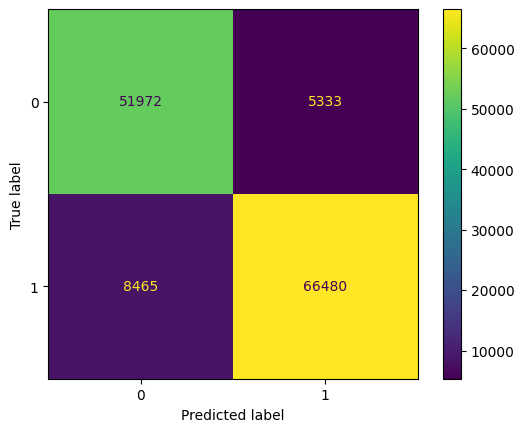

In [87]:
cm = confusion_matrix(y_test, logreg_y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

R2 Score: 0.57
              precision    recall  f1-score   support

           0     0.8588    0.9048    0.8812    133528
           1     0.9243    0.8866    0.9050    175054

    accuracy                         0.8945    308582
   macro avg     0.8916    0.8957    0.8931    308582
weighted avg     0.8960    0.8945    0.8947    308582



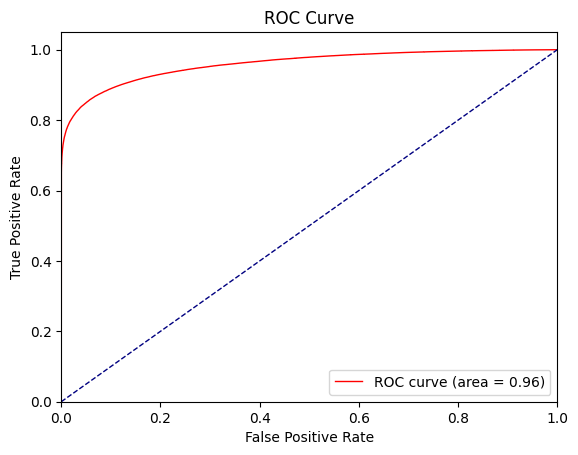

In [90]:
model_evaluation(y_train, logreg_y_train_pred, logreg_y_train_prob)

R2 Score: 0.58
              precision    recall  f1-score   support

           0     0.8599    0.9069    0.8828     57305
           1     0.9257    0.8871    0.9060     74945

    accuracy                         0.8957    132250
   macro avg     0.8928    0.8970    0.8944    132250
weighted avg     0.8972    0.8957    0.8959    132250



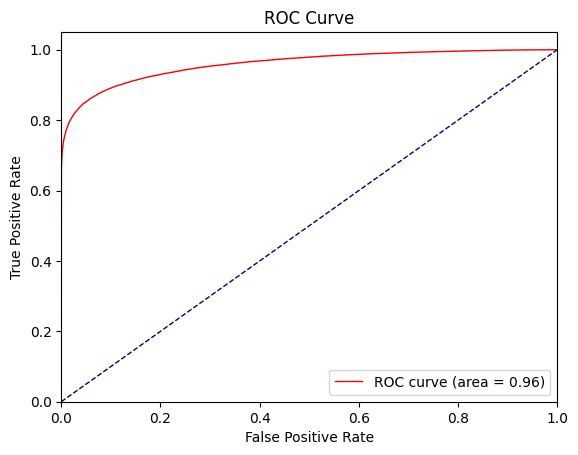

In [91]:
model_evaluation(y_test, logreg_y_test_pred, logreg_y_test_prob)

Comparing the performance of the train set and the test set, we can oberve that the performance of both is extremely good, and there is not much difference in performance between the two. However, the result is too good to be true. Here, I started to speculate that there are potentially data leakage problems since we are only splitting the original training data set. Moving forward, I tried to do a random forest to double check my speculation. 

### **Random Forest**

In [92]:
X = data.drop(['Churn'], axis=1)
y = data.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [63]:
rf = RandomForestClassifier()

rf_grid1 = {'n_estimators':[50, 100, 200],
            'max_depth':[None, 10, 20, 30],
            'min_samples_split':[2, 5, 10],
            'min_samples_leaf':[1, 2, 4]}

rf_grid_search1 = GridSearchCV(estimator=rf, param_grid=rf_grid1, cv=5, n_jobs=-1, verbose=0, scoring='f1')
rf_grid_search1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

I used the GridSearchCV to conduct hyperparameter tuning for the random forest model.

In [93]:
rf_grid_search1.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=200)

In [94]:
rf_grid_search1.best_score_

0.9994055380664839

In [115]:
rf = RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=200)

In [95]:
rf_y_train_pred = rf.predict(X_train)
rf_y_train_prob = rf.predict_proba(X_train)[:, 1]

rf_y_test_pred = rf.predict(X_test)
rf_y_test_prob = rf.predict_proba(X_test)[:, 1]

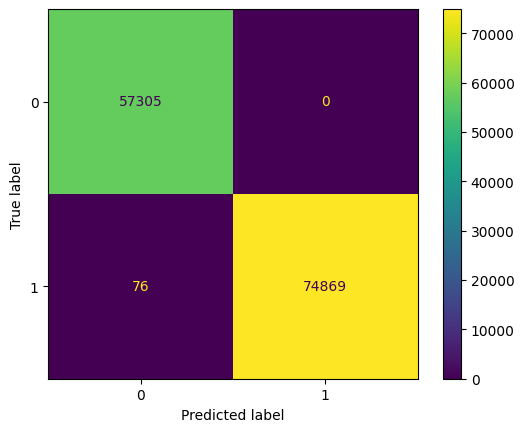

In [69]:
cm = confusion_matrix(y_test, rf_y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

R2 Score: 1.00
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    133673
           1     1.0000    1.0000    1.0000    174909

    accuracy                         1.0000    308582
   macro avg     1.0000    1.0000    1.0000    308582
weighted avg     1.0000    1.0000    1.0000    308582



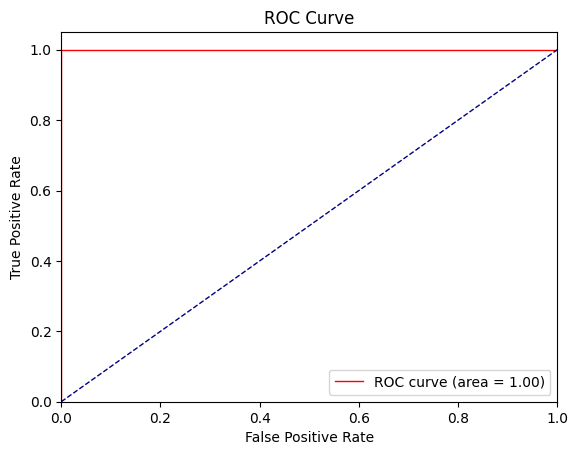

In [97]:
model_evaluation(y_train, rf_y_train_pred, rf_y_train_prob)

R2 Score: 1.00
              precision    recall  f1-score   support

           0     0.9979    1.0000    0.9989     57160
           1     1.0000    0.9984    0.9992     75090

    accuracy                         0.9991    132250
   macro avg     0.9989    0.9992    0.9991    132250
weighted avg     0.9991    0.9991    0.9991    132250



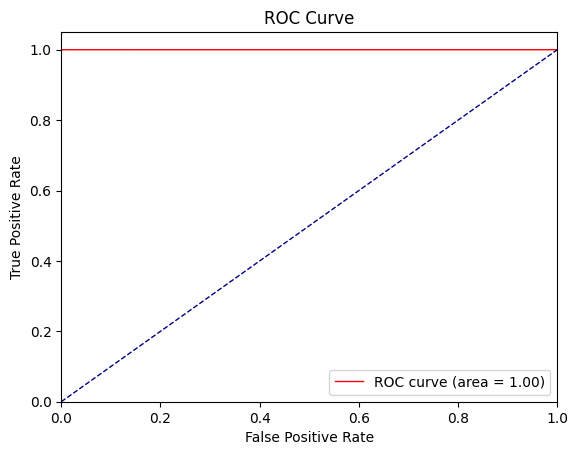

In [98]:
model_evaluation(y_test, rf_y_test_pred, rf_y_test_prob)

Here, it is very obvious that there are information leakage problems. The model has unbelievable low bias and low variance, which, in real case scenario, is nearly impossible.

## **Fitting the test set**

I tried to use the test set that the data set provides to see the performance.

In [ ]:
test = dataprep_EDA(r'C:\Users\alan\Desktop\Project\Churn Prediction\dataset\customer_churn_dataset-testing-master.csv')
test.head()

,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn
0,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [ ]:
test.Gender = test.Gender.apply(lambda x: 1 if x == 'Male' else 0)
test = pd.get_dummies(test, columns=['SubscriptionType', 'ContractLength'])
test.head()

,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,TotalSpend,LastInteraction,Churn,SubscriptionType_Basic,SubscriptionType_Premium,SubscriptionType_Standard,ContractLength_Annual,ContractLength_Monthly,ContractLength_Quarterly
0,22,0,25,14,4,27,598,9,1,1,0,0,0,1,0
1,41,0,28,28,7,13,584,20,0,0,0,1,0,1,0
2,47,1,27,10,2,29,757,21,0,0,1,0,1,0,0
3,35,1,9,12,5,17,232,18,0,0,1,0,0,0,1
4,53,0,58,24,9,2,533,18,0,0,0,1,1,0,0


In [ ]:
def evaluate_threshold(y, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    print(f'Threshold: {threshold:.2f}')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('-' * 30)

    return accuracy, precision, recall, f1


### **Random Forest - Test Set**

In [136]:
X_test = test.drop(['Churn'], axis=1)
y_test = test.Churn

rf_y_test_pred = rf.predict(X_test)
rf_y_test_prob = rf.predict_proba(X_test)[:, 1]

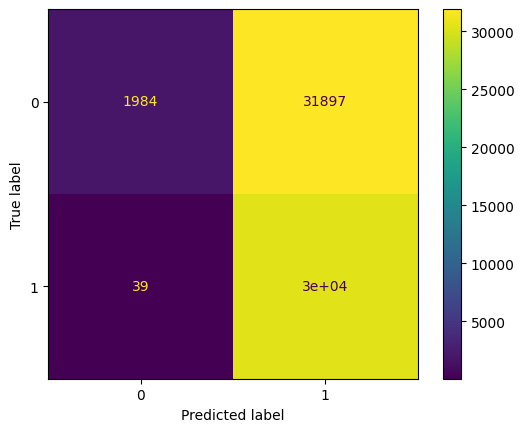

In [137]:
cm = confusion_matrix(y_test, rf_y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Threshold: 0.00
Accuracy: 0.47
Precision: 0.47
Recall: 1.00
F1 Score: 0.64
------------------------------
Threshold: 0.10
Accuracy: 0.50
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.20
Accuracy: 0.50
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.30
Accuracy: 0.50
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.40
Accuracy: 0.50
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.50
Accuracy: 0.50
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.60
Accuracy: 0.50
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.70
Accuracy: 0.51
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.80
Accuracy: 0.51
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.90
Accuracy: 0.51
Precision: 0.49

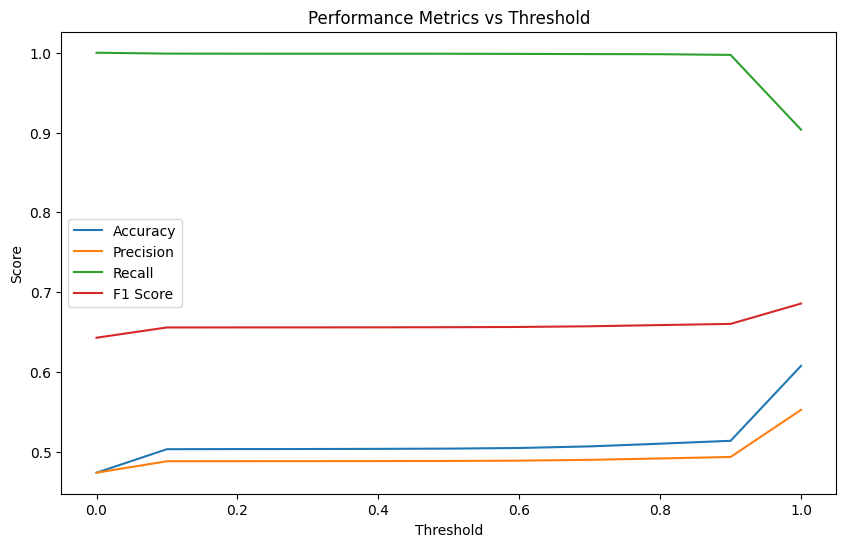

In [138]:
thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    metrics = evaluate_threshold(y_test, rf_y_test_prob, threshold)
    results.append((threshold, *metrics))

results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall')
plt.plot(results_df['Threshold'], results_df['F1 Score'], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Threshold')
plt.legend()
plt.show()

R2 Score: -0.99
              precision    recall  f1-score   support

           0     0.9807    0.0586    0.1105     33881
           1     0.4884    0.9987    0.6560     30493

    accuracy                         0.5039     64374
   macro avg     0.7346    0.5286    0.3833     64374
weighted avg     0.7475    0.5039    0.3689     64374



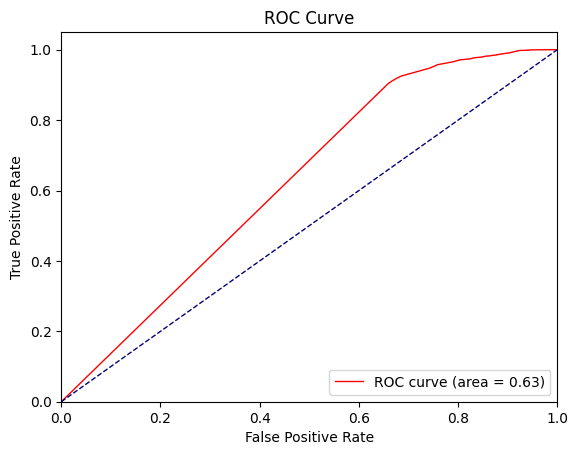

In [139]:
rf_y_test_pred_best = (rf_y_test_prob >= 0.5).astype(int)
model_evaluation(y_test, rf_y_test_pred_best, rf_y_test_prob)

The random forest model is not performing well based on the metrics and ROC curve. The overall accuracy and AUC indicate that the model's predictive power is quite low. You may need to consider feature engineering, hyperparameter tuning, or trying different algorithms to improve the model's performance.

### **Logistic Regression (L2) - Test Set**

In [140]:
X_test = test[columns_to_pick]
y_test = test.Churn

logreg_y_test_pred = logreg.predict(X_test)
logreg_y_test_prob = logreg.predict_proba(X_test)[:, 1]

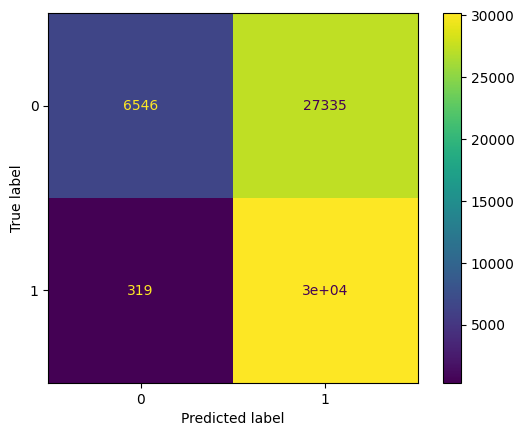

In [141]:
cm = confusion_matrix(y_test, logreg_y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Threshold: 0.00
Accuracy: 0.47
Precision: 0.47
Recall: 1.00
F1 Score: 0.64
------------------------------
Threshold: 0.10
Accuracy: 0.51
Precision: 0.49
Recall: 1.00
F1 Score: 0.66
------------------------------
Threshold: 0.20
Accuracy: 0.53
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Threshold: 0.30
Accuracy: 0.54
Precision: 0.51
Recall: 1.00
F1 Score: 0.67
------------------------------
Threshold: 0.40
Accuracy: 0.56
Precision: 0.52
Recall: 0.99
F1 Score: 0.68
------------------------------
Threshold: 0.50
Accuracy: 0.57
Precision: 0.52
Recall: 0.99
F1 Score: 0.69
------------------------------
Threshold: 0.60
Accuracy: 0.59
Precision: 0.53
Recall: 0.98
F1 Score: 0.69
------------------------------
Threshold: 0.70
Accuracy: 0.60
Precision: 0.54
Recall: 0.97
F1 Score: 0.70
------------------------------
Threshold: 0.80
Accuracy: 0.62
Precision: 0.56
Recall: 0.96
F1 Score: 0.70
------------------------------
Threshold: 0.90
Accuracy: 0.64
Precision: 0.57

c:\Users\alan\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


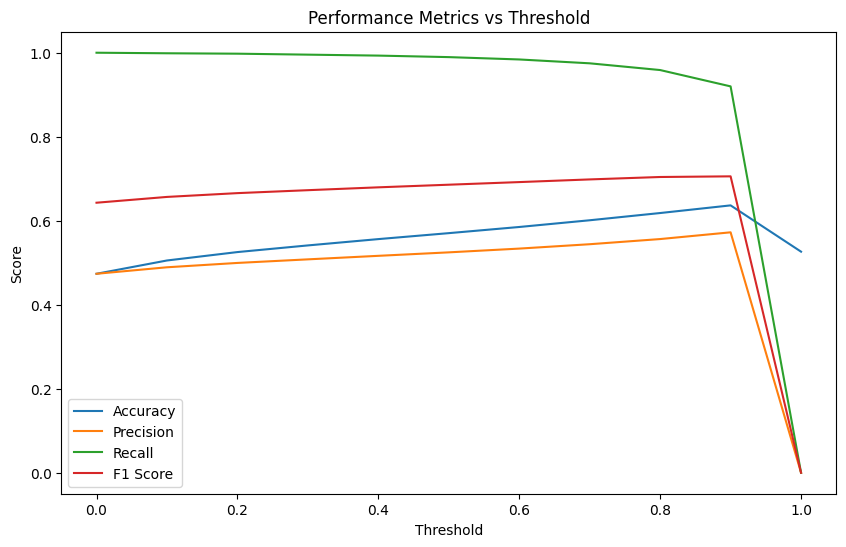

In [142]:
thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    metrics = evaluate_threshold(y_test, logreg_y_test_prob, threshold)
    results.append((threshold, *metrics))

results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall')
plt.plot(results_df['Threshold'], results_df['F1 Score'], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs Threshold')
plt.legend()
plt.show()

R2 Score: -0.46
              precision    recall  f1-score   support

           0     0.8410    0.3815    0.5249     33881
           1     0.5724    0.9199    0.7057     30493

    accuracy                         0.6365     64374
   macro avg     0.7067    0.6507    0.6153     64374
weighted avg     0.7138    0.6365    0.6105     64374



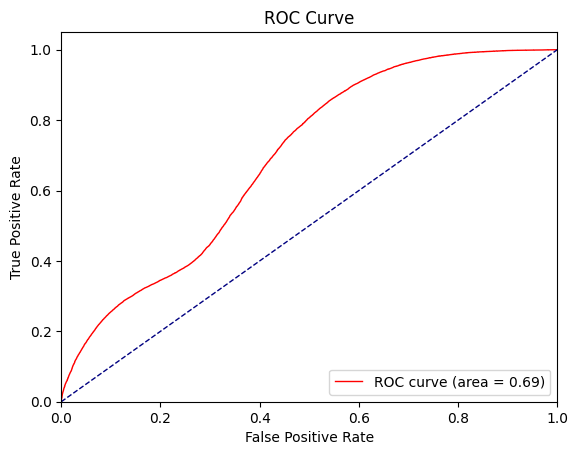

In [143]:
logreg_y_test_pred_best = (logreg_y_test_prob >= 0.9).astype(int)
model_evaluation(y_test, logreg_y_test_pred_best, logreg_y_test_prob)

The logistic regression model is performing moderately well. It has improved overall accuracy and better balance in precision and recall compared to the previous random forest model.

## **Future Consideration**

There are some techniques we can implement in the future to potentially improve the overall performance of the models.
1. Change one-hot encoding to dummy encoding: Dummy encoding can reduce the overall dimentionality, but in this case, since most of the categorical variables are not selected as variables, this improvement will not affect the overall performance.
2. Use k-fold cross validation to train the model: Implemeting k-fold cross validation can potentially improve the variance of the model and reduce the risk of overfitting. However, in this specific case, since the data set provided has already specify the training and testing set, using k-fold cross validation might not be applied in this case.
3. Implement ensemble learning to improve the performace: Adaboost, Gradient Boost or even bagging might be considered to improve the predictability of the models.